#Welcome to our Project 4 regressor notebook!

Here we will create multiple regression tech. to predict daily high, low, wind speed and precip over Champaign IL. 

First up, clone the repository. 

In [0]:
# get our project github directory 
!git clone https://github.com/mitraarka27/ATMS-597-SP-2020-Project4-GroupG.git

Cloning into 'ATMS-597-SP-2020-Project4-GroupG'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 159 (delta 14), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (159/159), 109.56 MiB | 38.74 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [0]:
#open up the data archives (puts them in the current dir under ./bufkit)
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/daily.tar.gz
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/prof.tar.gz
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/sfc.tar.gz

The files we have are the following: 

1) YYYYMMDDHH.gfs_kcmi.buf_daily.csv

2) YYYYMMDDHH.gfs_kcmi.buf_sfc.csv

3) YYYYMMDDHH.gfs_kcmi.buf_prof.csv

 ---

The next cell defines the main class. This will do most the heavy lifting

# Data Prep 

In [0]:
import pandas as pd 
import glob 
%pylab inline 

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'

%config InlineBackend.figure_format = 'retina'

class wxchallenge():

  """ 
  ATMS 597: Project 4 Group G. 
  Authors: Randy Chase, Arka _____, Rylan ____ 

  This is the main class for Project 4. Intended to improve numerical weather
  prediction for KCMI. Here we will just the MOS output, GFS profile data and 
  GFS surface data to do the inference. Specifically, linear regression and 
  random forest models will be used. 

  """

  def __init__(self):
    
    self.intialized = True
  
  def preprocess_daily(self):

    """
    Method to preprocess the daily forecast files (most simple model). This is
    the MOS output from the GFS. This is already fit to an extent (look up MOS
    Forecasts https://www.weather.gov/mdl/mos_gfsmos_home )

    Effectively this loads all the files into one big dataframe. Then we split
    the data into training and testing (2010-2018 and 2019). Fill with NaNs for
    missing days/forecasts

    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_daily.csv')
    filenames.sort()

    dfs = []
    for i in filenames:
      dfs.append(pd.read_csv(i))

    df_temp = pd.concat(dfs)
    df_forecast = pd.DataFrame(data={'MaxT':df_temp['TMAX'].values,'MinT':df_temp['TMIN'].values,'WMAX':df_temp['WMAX'].values,'PTOT':df_temp['RTOT'].values*25.4,},index=pd.to_datetime(pd.to_datetime(df_temp['Unnamed: 0'].values).date)+datetime.timedelta(days=1))

    #split the data into train and test 
    df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2018-12-31')]
    df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-30')
    df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)

    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)

    self.daily_train = df_forecast_train
    self.daily_test = df_forecast_test

  def preprocess_profs(self):

    """

    Similar to the daily processing, we do this for the profiles of data out of 
    the GFS deterministic run. Right now it just makes a dataframe with all 
    profile datapoints as a feature that can be used for inference. 

    Split of train and test are the same as daily

    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_prof.csv')
    filenames.sort()



    df_list = []
    for i in filenames:
      df = pd.read_csv(i)
      index = pd.to_datetime(df['Unnamed: 0'])
      index.name = 'Time'
      df_new = make_big_df(df,index)
      df_list.append(df_new)

    df_big = pd.concat(df_list)

    #drop 100mb Dew. its all nan 
    df_big = df_big.drop(columns='DWPC_100_0')
    #fill nans with average value of the column
    df_big = df_big.apply(lambda x: x.fillna(x.mean()),axis=0)

    # split the data into train and test 
    df_prof_train = df_big.iloc[df_big.index.values < np.datetime64('2018-12-31')]
    df_prof_test = df_big.iloc[df_big.index.values >= np.datetime64('2019-01-01')]

    # valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-30')
    df_prof_train = df_prof_train.reindex(index=dtime_index_train)

    # #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_prof_test = df_prof_test.reindex(index=dtime_index_test)

    self.prof_train = df_prof_train
    self.prof_test = df_prof_test

  def preprocess_sfc(self):

    """

    Similar to the previous two methods. But now for the surface params. For
    example it includes the Td forecast every 3 hours for 6 - 6 UTC. 

    Train and test is the same as before. 

    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_sfc.csv')
    filenames.sort()

    df_list = []
    for i in filenames:
      df = pd.read_csv(i)
      time = list(df.keys())[1]
      dtime = pd.to_datetime(pd.to_datetime(time).date())
      names_td = ['TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',]
      names_t = ['T_surf_0','T_surf_1','T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8',]
      names_p = ['P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8',]
      names_u = ['U_surf_0','U_surf_1','U_surf_2','U_surf_3','U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8',]
      names_v = ['V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5','V_surf_6','V_surf_7','V_surf_8',]
      td = df.iloc[0].values[1:].astype('float')
      p = df.iloc[4].values[1:].astype('float')
      t = df.iloc[6].values[1:].astype('float')
      u = df.iloc[7].values[1:].astype('float')
      v = df.iloc[8].values[1:].astype('float')

      mat_all = np.hstack([td,p,t,u,v])
      mat_all = np.reshape(mat_all,[1,45])
      names_all = np.hstack([names_td,names_p,names_t,names_u,names_v])
      df_new = pd.DataFrame(data=mat_all,columns=names_all,index=[dtime])
      df_list.append(df_new)

    df_big = pd.concat(df_list)  

    # split the data into train and test 
    df_sfc_train = df_big.iloc[df_big.index.values < np.datetime64('2018-12-31')]
    df_sfc_test = df_big.iloc[df_big.index.values >= np.datetime64('2019-01-01')]

    # valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-30')
    df_sfc_train = df_sfc_train.reindex(index=dtime_index_train)

    # #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_sfc_test = df_sfc_test.reindex(index=dtime_index_test)

    self.sfc_train = df_sfc_train
    self.sfc_test = df_sfc_test

  def preprocess_truth(self):

    """
    Method to preprocess the observations. This is our 'truth' dataset. Or the 
    data we want to predict. 

    Train and test are the same as above. 
    """

    #load the truth data (default from Steve)
    # truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
    # truth_df = truth_df.drop(columns='Unnamed: 5')
    # truth_df = truth_df.dropna(how='any')

    #reprocessed to get precip right. 
    truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

    series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values,'PTOT':truth_df['Total Precip (in)'].values},index=pd.to_datetime(truth_df['Date'].values))

    #split into train and test 
    df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2018-12-31')]
    df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

    #fill missing values with np.nan
    df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.WMAX != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.PTOT >= 0.0))
    #convert to floats and deg C 
    df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
    df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_train.WMAX  = (df_obs_train.WMAX.astype(float)) * 0.44704
    #convert to floats 
    df_obs_train.PTOT  = (df_obs_train.PTOT.astype(float)) 

    #fill missing values with np.nan
    df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.WMAX != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.PTOT >= 0.0))
    #convert to floats and deg C 
    df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
    df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_test.WMAX  = (df_obs_test.WMAX.astype(float)) * 0.44704
    #convert to floats 
    df_obs_test.PTOT  = (df_obs_test.PTOT.astype(float)) 

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-30')
    df_obs_train = df_obs_train.reindex(index=dtime_index_train)
    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_obs_test = df_obs_test.reindex(index=dtime_index_test)

    self.obs_train = df_obs_train
    self.obs_test = df_obs_test

  def run_simple_regressor_random_forest(self,n_estimators=None,max_depth=None,ensemble=False,n_ensembles=2):

    """
    This method preps the loaded data for use in the sklearn random forest 
    regressor. It scales the features and then gives the X,y to the regressor
    class. 

    NOTE: This uses only 1 feature as a predictor. Specifically the MOS forecast. 
    This was done to see the baseline/simplest model. 

    """
    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    regress_dict = {}
    for i in keys: 
      X_train =self.daily_train[i].values
      y_train =self.obs_train[i].values
      X_test = self.daily_test[i].values
      y_test = self.obs_test[i].values
      X_train,X_test,y_train,y_test = dropna(X_train,X_test,y_train,y_test)
      #reshape as needed 
      X_train = X_train.reshape(X_train.shape[0],1)
      X_test = X_test.reshape(X_test.shape[0],1)

      #scale it (mean 0, std 1)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      self.X_train =  X_train_scaled
      self.X_test = X_test_scaled
      self.y_train = y_train
      self.y_test = y_test 
      regress = regressor(wxobj=self)
      if ensemble:
        regress.ensemble_random_forest(n_estimators=n_estimators,max_depth=max_depth,n_ensembles=n_ensembles)
      else:
        regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)

      regress_dict[i] = regress

    self.regress_dict = regress_dict

  def run_simple_regressor_random_forest_2(self,n_estimators=None,max_depth=None,ensemble=False,n_ensembles=2):

    """
    This method preps the loaded data for use in the sklearn random forest 
    regressor. It scales the features and then gives the X,y to the regressor
    class. 

    NOTE: This uses all daily obs to do the inference. Specifically the MOS forecast. 
    This was done to see the baseline/simplest model. 

    """
    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    regress_dict = {}
    X_train = np.zeros([self.daily_train['MaxT'].values.shape[0],4])
    X_test = np.zeros([self.daily_test['MaxT'].values.shape[0],4])
    y_train = np.zeros([self.daily_train['MaxT'].values.shape[0],4])
    y_test = np.zeros([self.daily_test['MaxT'].values.shape[0],4])
    for i,ii in enumerate(keys): 
      X_train[:,i] =self.daily_train[ii].values
      y_train[:,i] =self.obs_train[ii].values
      X_test[:,i] = self.daily_test[ii].values
      y_test[:,i] = self.obs_test[ii].values

    # from IPython.core.debugger import Tracer; Tracer()() 
    X_train,X_test,y_train,y_test = dropna_2DXy(X_train,X_test,y_train,y_test)

    #scale it (mean 0, std 1)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    self.X_train =  X_train_scaled
    self.X_test = X_test_scaled
    self.y_train = y_train
    self.y_test = y_test 
    regress = regressor(wxobj=self)
    if ensemble:
      regress.ensemble_random_forest(n_estimators=n_estimators,max_depth=max_depth,n_ensembles=n_ensembles)
    else:
      regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)

    self.regress_dict = regress

  def run_complex_regressor_random_forest(self,n_estimators=None,max_depth=None,ensemble=False,n_ensembles=2):

    """
    This method throws everything at the model, including the kitchen sink in 
    hopes of improving the inference. 

    Warning! this takes a bit to train because of all the features... 

    """

    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    # keys = ['MaxT']
    regress_dict = {}
    for i in keys: 

      daily = self.daily_train[i].values
      prof = self.prof_train.values
      sfc = self.sfc_train.values
      # from IPython.core.debugger import Tracer; Tracer()() 
      X_train = np.zeros([daily.shape[0],1+prof.shape[1]+sfc.shape[1]])
      X_train[:,0] = daily
      X_train[:,1:1+prof.shape[1]] = prof
      X_train[:,1+prof.shape[1]:] = sfc

      
      y_train = self.obs_train[i].values

      daily = self.daily_test[i].values
      prof = self.prof_test.values
      sfc = self.sfc_test.values
      X_test = np.zeros([daily.shape[0],1+prof.shape[1]+sfc.shape[1]])
      X_test[:,0] = daily
      X_test[:,1:1+prof.shape[1]] = prof
      X_test[:,1+prof.shape[1]:] = sfc

      y_test = self.obs_test[i].values

      X_train,X_test,y_train,y_test = dropna_2DX(X_train,X_test,y_train,y_test)

      #scale it (mean 0, std 1)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      self.X_train =  X_train_scaled
      self.X_test = X_test_scaled
      self.y_train = y_train
      self.y_test = y_test 
      regress = regressor(wxobj=self)
      if ensemble:
        regress.ensemble_random_forest(n_estimators=n_estimators,max_depth=max_depth,n_ensembles=n_ensembles)
      else:
        regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)

      regress_dict[i] = regress

    self.regress_dict_complex = regress_dict

class regressor:
  """ 

  This class is to help do the inference. It is just a generalzied form of the 
  sklearn package. It needs the wxobject that has a key X_train,X_test,y_train,
  y_test

  """
  def __init__(self,wxobj=None):
    self.initialized = True
    self.wxobj = wxobj
  def random_forest(self,n_estimators=None, max_depth=None):
    if n_estimators is None:
      n_estimators = 100

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
    regr.fit(self.wxobj.X_train, self.wxobj.y_train)
    self.regr = regr 
    if len(self.wxobj.y_train.shape) > 1:
      pass
    else:
      self.score_train = regr.score(self.wxobj.X_train,self.wxobj.y_train)
      self.score_test= regr.score(self.wxobj.X_test,self.wxobj.y_test)
      self.yhat_test = regr.predict(self.wxobj.X_test)
      self.yhat_train = regr.predict(self.wxobj.X_train)
      self.y_train = self.wxobj.y_train
      self.y_test = self.wxobj.y_test

      self.rmse_test = np.sqrt(mean_squared_error(self.y_test, self.yhat_test))
      self.rmse_train = np.sqrt(mean_squared_error(self.y_train, self.yhat_train))
      self.mae_test = np.mean(np.abs(self.yhat_test-self.y_test))
      self.mae_train = np.mean(np.abs(self.yhat_train-self.y_train))

  def ensemble_random_forest(self,n_ensembles=2,n_estimators=None, max_depth=None):

    if n_estimators is None:
      n_estimators = 100

    from sklearn.ensemble import BaggingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error

    regr = BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators),n_estimators=n_ensembles,n_jobs=2)
    regr.fit(self.wxobj.X_train, self.wxobj.y_train)

    self.regr = regr 
    self.score_train = regr.score(self.wxobj.X_train,self.wxobj.y_train)
    self.score_test= regr.score(self.wxobj.X_test,self.wxobj.y_test)
    self.yhat_test = regr.predict(self.wxobj.X_test)
    self.yhat_train = regr.predict(self.wxobj.X_train)
    self.y_train = self.wxobj.y_train
    self.y_test = self.wxobj.y_test

    self.rmse_test = np.sqrt(mean_squared_error(self.y_test, self.yhat_test))
    self.rmse_train = np.sqrt(mean_squared_error(self.y_train, self.yhat_train))
    self.mae_test = np.mean(np.abs(self.yhat_test-self.y_test))
    self.mae_train = np.mean(np.abs(self.yhat_train-self.y_train))

###############################################################################
###################          Auxiliary functions         ######################
###############################################################################

def build_mat(column_data):
  mat = np.zeros([len(column_data),6])
  for i in np.arange(0,len(column_data)):
    mat[i,:] = strip_split_assign(column_data[i])
  return mat

def make_big_df(df,dtime):
  list_o_keys = list(df.keys())
  list_o_dfs = []
  mats = []
  all_names = []
  for i in list_o_keys:
    if (i == 'Unnamed: 0') or (i =='PRES'):
      continue
    names = []
    for j in np.array([925,850,700,500,250,100]):
      names.append(i + '_'+str(j))
    
    all_names.append(names)
    mats.append(build_mat(df[i]))
  
  mat_all = np.hstack(mats)
  mat_all = np.ravel(mat_all)
  mat_all = np.reshape(mat_all,[1,270])
  name_all = np.hstack(all_names)
  names_mat = create_name_matrix(name_all)
  names_mat = np.ravel(names_mat)
  df_new = pd.DataFrame(data=mat_all,columns=names_mat,index=[pd.to_datetime(dtime[0].date())])
  return df_new

def strip_split_assign(ugly_format):
  ugly_format = ugly_format.strip('[]')
  ugly_format = ugly_format.split(',')
  good_format = np.asarray(ugly_format,dtype=float)
  return good_format

def dropna(X_train,X_test,y_train,y_test):

    ind = np.isnan(X_train)
    X_train = X_train[~ind]
    y_train = y_train[~ind]
    ind = np.isnan(y_train)
    X_train = X_train[~ind]
    y_train = y_train[~ind]
    ind = np.isnan(X_test)
    X_test = X_test[~ind]
    y_test = y_test[~ind]
    ind = np.isnan(y_test)
    X_test = X_test[~ind]
    y_test = y_test[~ind]

    return X_train,X_test,y_train,y_test

def dropna_2DX(X_train,X_test,y_train,y_test):

    # from IPython.core.debugger import Tracer; Tracer()() 
    ind = np.isnan(X_train)
    ind = ind[:,0]
    X_train = X_train[~ind,:]
    y_train = y_train[~ind]
    ind = np.isnan(y_train)
    X_train = X_train[~ind,:]
    y_train = y_train[~ind]

    ind = np.isnan(X_test)
    ind = ind[:,0]
    X_test = X_test[~ind,:]
    y_test = y_test[~ind]
    ind = np.isnan(y_test)
    X_test = X_test[~ind,:]
    y_test = y_test[~ind]

    return X_train,X_test,y_train,y_test

def dropna_2DXy(X_train,X_test,y_train,y_test):

    # from IPython.core.debugger import Tracer; Tracer()() 
    ind = np.isnan(X_train)
    ind = ind[:,0]
    X_train = X_train[~ind,:]
    y_train = y_train[~ind,:]
    ind = np.isnan(y_train)
    ind = ind[:,0]
    X_train = X_train[~ind,:]
    y_train = y_train[~ind,:]

    ind = np.isnan(X_test)
    ind = ind[:,0]
    X_test = X_test[~ind,:]
    y_test = y_test[~ind,:]
    ind = np.isnan(y_test)
    ind = ind[:,0]
    X_test = X_test[~ind,:]
    y_test = y_test[~ind,:]

    return X_train,X_test,y_train,y_test

def create_name_matrix(names):
  names_mat = np.zeros([9,30],dtype=object) 

  for k in np.arange(0,9):
    filler = np.ones(30,dtype=int)*k
    filler = np.asarray(filler,dtype=str)
    res = []
    for i in list(zip(names.tolist(),filler.tolist())):
      res.append(i[0]+'_'+i[1])

    names_mat[k,:] = res    
  return names_mat

Populating the interactive namespace from numpy and matplotlib


In [0]:
#let us actually run the class methods 
wx = wxchallenge()
wx.preprocess_daily()
wx.preprocess_truth()
wx.preprocess_profs()
wx.preprocess_sfc()

# Just MOS data

#### Training Data

In [0]:
# change forecast column names and merge the forecast and observational data
wx.daily_train.columns = ['GFS_MaxT','GFS_MinT', 'GFS_WMAX','GFS_PTOT']
data = wx.daily_train.join(wx.obs_train[['MaxT','MinT','WMAX','PTOT']])
data.dropna(axis=0, how='any', inplace=True)
data.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT
2010-01-02,-11.26,-16.46,7.323933,1.270,-14.444444,-20.555556,6.70560,0.0
2010-01-03,-10.16,-15.96,4.687217,0.000,-12.222222,-21.111111,4.91744,0.0
2010-01-04,-9.96,-14.36,5.941380,1.524,-11.666667,-18.888889,8.94080,0.0
2010-01-05,-8.46,-12.86,5.685068,4.318,-12.222222,-18.333333,7.15264,0.0
2010-01-06,-7.16,-11.06,3.794733,19.558,-7.777778,-19.444444,3.57632,0.0


In [0]:
# Create linear regression model for all variables and add predictions to dataframe

from sklearn.linear_model import LinearRegression

column_names = ['GFS_MaxT']
column_names2 = ['GFS_MinT']
column_names3 = ['GFS_WMAX']
column_names4 = ['GFS_PTOT']

X = data[column_names]
X2 = data[column_names2]
X3 = data[column_names3]
X4 = data[column_names4]

y = data['MaxT']
y2 = data['MinT']
y3 = data['WMAX']
y4 = data['PTOT']

model = LinearRegression(fit_intercept=True, normalize=True)
model2 = LinearRegression(fit_intercept=True, normalize=True)
model3 = LinearRegression(fit_intercept=True, normalize=True)
model4 = LinearRegression(fit_intercept=True, normalize=True)

model.fit(X, y)
model2.fit(X2, y2)
model3.fit(X3, y3)
model4.fit(X4, y4)

data['predicted_MaxT'] = model.predict(X)
data['predicted_MinT'] = model2.predict(X2)
data['predicted_WMAX'] = model3.predict(X3)
data['predicted_PTOT'] = model4.predict(X4)
data.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT,predicted_MaxT,predicted_MinT,predicted_WMAX,predicted_PTOT
2010-01-02,-11.26,-16.46,7.323933,1.270,-14.444444,-20.555556,6.70560,0.0,-10.984728,-18.261773,9.220940,0.917129
2010-01-03,-10.16,-15.96,4.687217,0.000,-12.222222,-21.111111,4.91744,0.0,-9.839701,-17.735891,6.541787,0.897160
2010-01-04,-9.96,-14.36,5.941380,1.524,-11.666667,-18.888889,8.94080,0.0,-9.631514,-16.053068,7.816136,0.921123
2010-01-05,-8.46,-12.86,5.685068,4.318,-12.222222,-18.333333,7.15264,0.0,-8.070112,-14.475422,7.555698,0.965056
2010-01-06,-7.16,-11.06,3.794733,19.558,-7.777778,-19.444444,3.57632,0.0,-6.716898,-12.582246,5.634939,1.204690


In [0]:
# Compute RMSE and save to variables for plotting
from sklearn.metrics import mean_squared_error as rmse

print(sqrt(rmse(data['MaxT'],data['predicted_MaxT'])))
print(sqrt(rmse(data['MinT'],data['predicted_MinT'])))
print(sqrt(rmse(data['WMAX'],data['predicted_WMAX'])))
print(sqrt(rmse(data['PTOT'],data['predicted_PTOT'])))
MaxT_RMSE = sqrt(rmse(data['MaxT'],data['predicted_MaxT']))
MinT_RMSE = sqrt(rmse(data['MinT'],data['predicted_MinT']))
WMAX_RMSE = sqrt(rmse(data['WMAX'],data['predicted_WMAX']))
PTOT_RMSE = sqrt(rmse(data['PTOT'],data['predicted_PTOT']))

2.2044132796928553
2.0004895420357456
1.6691304693712925
5.434734352174404


#### Test Data

In [0]:
## Repeat process above for test data

wx.daily_test.columns = ['GFS_MaxT','GFS_MinT', 'GFS_WMAX','GFS_PTOT']
data2 = wx.daily_test.join(wx.obs_test[['MaxT','MinT','WMAX','PTOT']])
data2.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT
2019-01-01,3.54,-0.86,5.423099,12.700,2.777778,0.000000,6.25856,36.4
2019-01-02,1.54,-1.16,5.859181,3.556,0.000000,-2.222222,7.59968,0.3
2019-01-03,4.74,-2.26,4.609772,0.000,3.333333,-3.333333,6.25856,0.0
2019-01-04,5.24,-0.06,3.667424,0.000,3.888889,-3.888889,4.91744,0.0
2019-01-05,9.54,0.64,4.701064,0.000,10.555556,-1.111111,6.25856,0.0


In [0]:
data2.dropna(axis=0, how='any', inplace=True)
column_names = ['GFS_MaxT']
column_names2 = ['GFS_MinT']
column_names3 = ['GFS_WMAX']
column_names4 = ['GFS_PTOT']

X = data2[column_names]
X2 = data2[column_names2]
X3 = data2[column_names3]
X4 = data2[column_names4]

y = data2['MaxT']
y2 = data2['MinT']
y3 = data2['WMAX']
y4 = data2['PTOT']

model = LinearRegression(fit_intercept=True, normalize=True)
model2 = LinearRegression(fit_intercept=True, normalize=True)
model3 = LinearRegression(fit_intercept=True, normalize=True)
model4 = LinearRegression(fit_intercept=True, normalize=True)

model.fit(X, y)
model2.fit(X2, y2)
model3.fit(X3, y3)
model4.fit(X4, y4)

data2['predicted_MaxT'] = model.predict(X)
data2['predicted_MinT'] = model2.predict(X2)
data2['predicted_WMAX'] = model3.predict(X3)
data2['predicted_PTOT'] = model4.predict(X4)
data2.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT,predicted_MaxT,predicted_MinT,predicted_WMAX,predicted_PTOT
2019-01-01,3.54,-0.86,5.423099,12.700,2.777778,0.000000,6.25856,36.4,3.339803,-2.032703,6.821575,1.003905
2019-01-02,1.54,-1.16,5.859181,3.556,0.000000,-2.222222,7.59968,0.3,1.184233,-2.348845,7.302764,0.849656
2019-01-03,4.74,-2.26,4.609772,0.000,3.333333,-3.333333,6.25856,0.0,4.633145,-3.508035,5.924121,0.789670
2019-01-04,5.24,-0.06,3.667424,0.000,3.888889,-3.888889,4.91744,0.0,5.172038,-1.189656,4.884301,0.789670
2019-01-05,9.54,0.64,4.701064,0.000,10.555556,-1.111111,6.25856,0.0,9.806513,-0.451990,6.024856,0.789670


In [0]:
MaxT2_RMSE = sqrt(rmse(data2['MaxT'],data2['predicted_MaxT']))
MinT2_RMSE = sqrt(rmse(data2['MinT'],data2['predicted_MinT']))
WMAX2_RMSE = sqrt(rmse(data2['WMAX'],data2['predicted_WMAX']))
PTOT2_RMSE = sqrt(rmse(data2['PTOT'],data2['predicted_PTOT']))
print(sqrt(rmse(data2['MaxT'],data2['predicted_MaxT'])))
print(sqrt(rmse(data2['MinT'],data2['predicted_MinT'])))
print(sqrt(rmse(data2['WMAX'],data2['predicted_WMAX'])))
print(sqrt(rmse(data2['PTOT'],data2['predicted_PTOT'])))

2.000623596461399
1.921071753833216
1.61036806687363
4.67815134996379


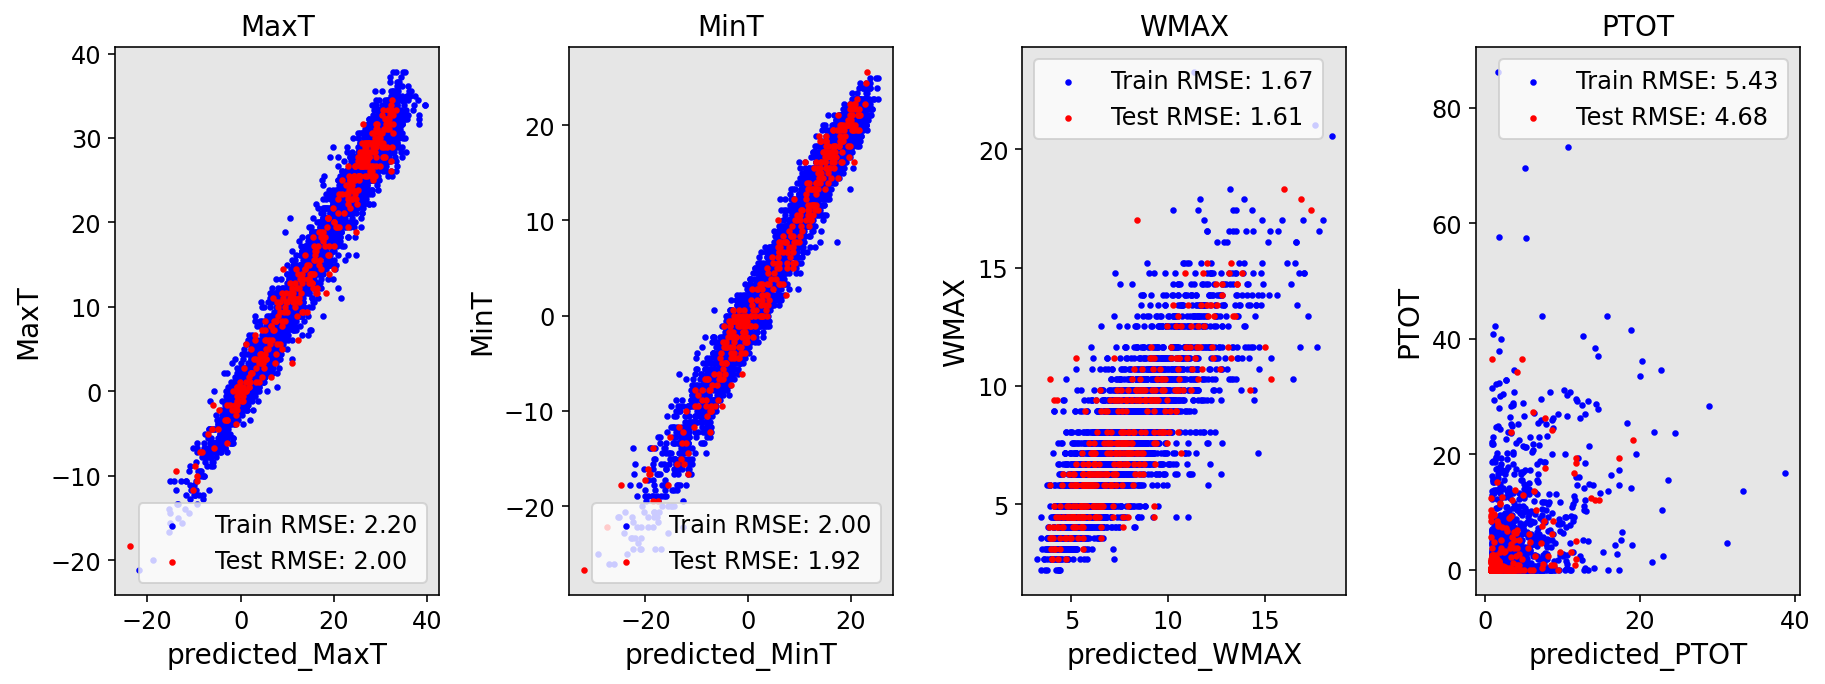

In [0]:
# Plot Results

plt.figure(figsize=(12,8))
ax = plt.subplot(141)
data.plot.scatter(x = 'predicted_MaxT', y = 'MaxT', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (MaxT_RMSE), ax=ax)
data2.plot.scatter(x = 'predicted_MaxT', y = 'MaxT', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (MaxT2_RMSE), ax=ax)
ax2 = plt.subplot(142)
data.plot.scatter(x = 'predicted_MinT', y = 'MinT', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (MinT_RMSE), ax=ax2)
data2.plot.scatter(x = 'predicted_MinT', y = 'MinT', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (MinT2_RMSE), ax=ax2)
ax3 = plt.subplot(143)
data.plot.scatter(x = 'predicted_WMAX', y = 'WMAX', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (WMAX_RMSE), ax=ax3)
data2.plot.scatter(x = 'predicted_WMAX', y = 'WMAX', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (WMAX2_RMSE), ax=ax3)
ax4 = plt.subplot(144)
data.plot.scatter(x = 'predicted_PTOT', y = 'PTOT', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (PTOT_RMSE), ax=ax4)
data2.plot.scatter(x = 'predicted_PTOT', y = 'PTOT', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (PTOT2_RMSE), ax=ax4)

ax.title.set_text('MaxT')
ax2.title.set_text('MinT')
ax3.title.set_text('WMAX')
ax4.title.set_text('PTOT')

plt.subplots_adjust(top = 0.6, right = 1.1, wspace = 0.4)
plt.show()

# Add surface and profile info

#### Training Data

In [0]:
data3 = wx.daily_train.join(wx.obs_train[['MaxT','MinT','WMAX','PTOT']])
data3.dropna(axis=0, how='any', inplace=True)
data3.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT
2010-01-02,-11.26,-16.46,7.323933,1.270,-14.444444,-20.555556,6.70560,0.0
2010-01-03,-10.16,-15.96,4.687217,0.000,-12.222222,-21.111111,4.91744,0.0
2010-01-04,-9.96,-14.36,5.941380,1.524,-11.666667,-18.888889,8.94080,0.0
2010-01-05,-8.46,-12.86,5.685068,4.318,-12.222222,-18.333333,7.15264,0.0
2010-01-06,-7.16,-11.06,3.794733,19.558,-7.777778,-19.444444,3.57632,0.0


In [0]:
# add daylight hours

%pylab inline
def hours_of_daylight(date, axis=23.44, latitude=40.116421):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

data3['daylight_hrs'] = list(map(hours_of_daylight, data.index))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


In [0]:
# Add surface and profile data 

data3 = data3.join(wx.sfc_train)
data3 = data3.join(wx.prof_train)
data3.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT,TD_surf_0,TD_surf_1,TD_surf_2,TD_surf_3,TD_surf_4,TD_surf_5,TD_surf_6,TD_surf_7,TD_surf_8,P_surf_0,P_surf_1,P_surf_2,P_surf_3,P_surf_4,P_surf_5,P_surf_6,P_surf_7,P_surf_8,T_surf_0,T_surf_1,T_surf_2,T_surf_3,T_surf_4,T_surf_5,T_surf_6,T_surf_7,T_surf_8,U_surf_0,U_surf_1,U_surf_2,U_surf_3,U_surf_4,...,UWND_700_7,UWND_500_7,UWND_250_7,UWND_100_7,VWND_925_7,VWND_850_7,VWND_700_7,VWND_500_7,VWND_250_7,VWND_100_7,DWPC_925_8,DWPC_850_8,DWPC_700_8,DWPC_500_8,DWPC_250_8,DWPC_100_8,HGHT_925_8,HGHT_850_8,HGHT_700_8,HGHT_500_8,HGHT_250_8,HGHT_100_8,TMPC_925_8,TMPC_850_8,TMPC_700_8,TMPC_500_8,TMPC_250_8,TMPC_100_8,UWND_925_8,UWND_850_8,UWND_700_8,UWND_500_8,UWND_250_8,UWND_100_8,VWND_925_8,VWND_850_8,VWND_700_8,VWND_500_8,VWND_250_8,VWND_100_8
2010-01-02,-11.26,-16.46,7.323933,1.270,-14.444444,-20.555556,6.70560,0.0,-13.74,-15.19,-17.91,-20.07,-18.81,-17.79,-18.55,-19.36,-19.79,0.0,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-11.26,-12.66,-14.76,-15.76,-13.86,-13.36,-15.26,-16.06,-16.46,4.3,4.9,4.2,4.3,4.6,...,24.840823,46.670103,75.194994,44.492985,-14.134741,-19.895924,-38.242046,-44.745111,-25.027749,-5.631817,-25.627500,-33.058302,-45.495597,-38.256713,-66.478358,-77.45901,820.549167,1458.304906,2932.431478,5437.138371,10082.642127,15963.980000,-16.143333,-15.216604,-13.564717,-25.654944,-57.889851,-55.840000,-1.975476,3.007115,20.205429,44.567533,71.176293,45.331369,-8.494141,-13.486745,-32.156633,-38.970599,-19.831462,-9.242547
2010-01-03,-10.16,-15.96,4.687217,0.000,-12.222222,-21.111111,4.91744,0.0,-18.27,-18.54,-18.81,-18.41,-15.09,-14.21,-15.61,-16.71,-16.84,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.36,-15.76,-15.96,-14.76,-10.66,-10.16,-12.96,-13.86,-14.26,1.5,2.2,2.5,1.5,2.1,...,4.517203,29.760959,23.705177,28.452585,-12.201104,-10.996784,-17.058931,-33.823197,-17.633164,-7.692015,-25.736667,-26.004340,-33.074543,-50.040507,-71.385768,-77.45901,814.494186,1462.346321,2940.111735,5396.740789,10038.357228,15942.590000,-12.670853,-11.294434,-16.238864,-30.925915,-53.851386,-53.760000,3.499557,3.498790,5.501196,26.546257,25.624138,27.317706,-13.226089,-11.597696,-17.739194,-31.636565,-13.489874,-5.806558
2010-01-04,-9.96,-14.36,5.941380,1.524,-11.666667,-18.888889,8.94080,0.0,-15.51,-15.94,-16.27,-15.94,-13.67,-12.63,-13.23,-13.51,-13.88,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,-13.66,-14.06,-14.36,-13.46,-10.56,-9.96,-11.46,-11.66,-11.96,2.7,3.4,3.9,4.0,4.3,...,3.863955,5.416036,12.217397,28.953472,-20.325887,-17.921532,-24.897778,-27.120477,-4.306438,-7.960981,-15.979302,-18.005118,-20.012286,-32.362712,-65.800562,-77.45901,795.587674,1443.041801,2924.047429,5399.847797,10021.178652,15895.138000,-13.232093,-11.312607,-15.205714,-29.338814,-58.225169,-54.880000,4.083795,3.717828,5.985816,6.708492,12.218160,30.221989,-16.103266,-16.601062,-24.111237,-28.190929,-3.098121,-11.192647
2010-01-05,-8.46,-12.86,5.685068,4.318,-12.222222,-18.333333,7.15264,0.0,-13.59,-14.16,-14.64,-14.24,-11.73,-10.75,-11.43,-12.14,-13.25,0.0,0.02,0.03,0.03,0.01,0.03,0.03,0.02,0.00,-11.86,-12.46,-12.86,-12.16,-9.36,-8.46,-9.86,-10.36,-11.66,4.3,4.4,4.0,3.9,4.6,...,11.689561,17.044808,33.106759,31.852935,-17.040128,-18.849077,-16.146781,-18.720673,-34.991843,-17.026463,-18.422791,-33.553223,-28.781519,-48.678754,-66.480827,-77.45901,794.294419,1448.270569,2936.809494,5416.427762,10061.734662,15886.162000,-10.715814,-8.623981,-14.790380,-28.913541,-57.486316,-56.720000,5.054817,9.076130,14.777655,20.133067,32.663580,33.047272,-13.453594,-16.445561,-14.603819,-19.954603,-35.743857,-18.464955
2010-01-06,-7.16,-11.06,3.794733,19.558,-7.777778,-19.444444,3.57632,0.0,-11.12,-11.82,-12.56,-12.39,-10.25,-9.45,-11.70,-10.07,-9.40,0.0,0.05,0.04,0.00,0.00,0.00,0.00,0.02,0.66,-9.86,-10.36,-11.06,-10.76,-7.86,-7.16,-10.36,-8.66,-8.06,2.8,3.3,3.6,2.2,2.3,...,25.554354,44.696472,75.902683,37.686253,1.456173,4.020252,1.902601,-3.375251,-0.495814,-12.866157,-12.294186,-11.705238,-15.528960,-29.674375,-65.749509,-

In [0]:
data3.dropna(axis=0, how='any', inplace=True)
column_names = ['GFS_MaxT', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','daylight_hrs','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

column_names2 = ['GFS_MinT', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','daylight_hrs','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

column_names3 = ['GFS_WMAX', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','daylight_hrs','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

column_names4 = ['GFS_PTOT', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','daylight_hrs','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

X = data3[column_names]
X2 = data3[column_names2]
X3 = data3[column_names3]
X4 = data3[column_names4]

y = data3['MaxT']
y2 = data3['MinT']
y3 = data3['WMAX']
y4 = data3['PTOT']

model = LinearRegression(fit_intercept=True, normalize=True)
model2 = LinearRegression(fit_intercept=True, normalize=True)
model3 = LinearRegression(fit_intercept=True, normalize=True)
model4 = LinearRegression(fit_intercept=True, normalize=True)

model.fit(X, y)
model2.fit(X2, y2)
model3.fit(X3, y3)
model4.fit(X4, y4)

data3['predicted_MaxT'] = model.predict(X)
data3['predicted_MinT'] = model2.predict(X2)
data3['predicted_WMAX'] = model3.predict(X3)
data3['predicted_PTOT'] = model4.predict(X4)
data3.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT,TD_surf_0,TD_surf_1,TD_surf_2,TD_surf_3,TD_surf_4,TD_surf_5,TD_surf_6,TD_surf_7,TD_surf_8,P_surf_0,P_surf_1,P_surf_2,P_surf_3,P_surf_4,P_surf_5,P_surf_6,P_surf_7,P_surf_8,T_surf_0,T_surf_1,T_surf_2,T_surf_3,T_surf_4,T_surf_5,T_surf_6,T_surf_7,T_surf_8,U_surf_0,U_surf_1,U_surf_2,U_surf_3,U_surf_4,...,VWND_925_7,VWND_850_7,VWND_700_7,VWND_500_7,VWND_250_7,VWND_100_7,DWPC_925_8,DWPC_850_8,DWPC_700_8,DWPC_500_8,DWPC_250_8,DWPC_100_8,HGHT_925_8,HGHT_850_8,HGHT_700_8,HGHT_500_8,HGHT_250_8,HGHT_100_8,TMPC_925_8,TMPC_850_8,TMPC_700_8,TMPC_500_8,TMPC_250_8,TMPC_100_8,UWND_925_8,UWND_850_8,UWND_700_8,UWND_500_8,UWND_250_8,UWND_100_8,VWND_925_8,VWND_850_8,VWND_700_8,VWND_500_8,VWND_250_8,VWND_100_8,predicted_MaxT,predicted_MinT,predicted_WMAX,predicted_PTOT
2010-01-02,-11.26,-16.46,7.323933,1.270,-14.444444,-20.555556,6.70560,0.0,-13.74,-15.19,-17.91,-20.07,-18.81,-17.79,-18.55,-19.36,-19.79,0.0,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-11.26,-12.66,-14.76,-15.76,-13.86,-13.36,-15.26,-16.06,-16.46,4.3,4.9,4.2,4.3,4.6,...,-14.134741,-19.895924,-38.242046,-44.745111,-25.027749,-5.631817,-25.627500,-33.058302,-45.495597,-38.256713,-66.478358,-77.45901,820.549167,1458.304906,2932.431478,5437.138371,10082.642127,15963.980,-16.143333,-15.216604,-13.564717,-25.654944,-57.889851,-55.84,-1.975476,3.007115,20.205429,44.567533,71.176293,45.331369,-8.494141,-13.486745,-32.156633,-38.970599,-19.831462,-9.242547,-10.905300,-18.741564,9.139532,-1.078808
2010-01-03,-10.16,-15.96,4.687217,0.000,-12.222222,-21.111111,4.91744,0.0,-18.27,-18.54,-18.81,-18.41,-15.09,-14.21,-15.61,-16.71,-16.84,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.36,-15.76,-15.96,-14.76,-10.66,-10.16,-12.96,-13.86,-14.26,1.5,2.2,2.5,1.5,2.1,...,-12.201104,-10.996784,-17.058931,-33.823197,-17.633164,-7.692015,-25.736667,-26.004340,-33.074543,-50.040507,-71.385768,-77.45901,814.494186,1462.346321,2940.111735,5396.740789,10038.357228,15942.590,-12.670853,-11.294434,-16.238864,-30.925915,-53.851386,-53.76,3.499557,3.498790,5.501196,26.546257,25.624138,27.317706,-13.226089,-11.597696,-17.739194,-31.636565,-13.489874,-5.806558,-10.090145,-17.454787,6.289470,0.528098
2010-01-04,-9.96,-14.36,5.941380,1.524,-11.666667,-18.888889,8.94080,0.0,-15.51,-15.94,-16.27,-15.94,-13.67,-12.63,-13.23,-13.51,-13.88,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,-13.66,-14.06,-14.36,-13.46,-10.56,-9.96,-11.46,-11.66,-11.96,2.7,3.4,3.9,4.0,4.3,...,-20.325887,-17.921532,-24.897778,-27.120477,-4.306438,-7.960981,-15.979302,-18.005118,-20.012286,-32.362712,-65.800562,-77.45901,795.587674,1443.041801,2924.047429,5399.847797,10021.178652,15895.138,-13.232093,-11.312607,-15.205714,-29.338814,-58.225169,-54.88,4.083795,3.717828,5.985816,6.708492,12.218160,30.221989,-16.103266,-16.601062,-24.111237,-28.190929,-3.098121,-11.192647,-9.394555,-16.312220,7.843805,-0.971479
2010-01-05,-8.46,-12.86,5.685068,4.318,-12.222222,-18.333333,7.15264,0.0,-13.59,-14.16,-14.64,-14.24,-11.73,-10.75,-11.43,-12.14,-13.25,0.0,0.02,0.03,0.03,0.01,0.03,0.03,0.02,0.00,-11.86,-12.46,-12.86,-12.16,-9.36,-8.46,-9.86,-10.36,-11.66,4.3,4.4,4.0,3.9,4.6,...,-17.040128,-18.849077,-16.146781,-18.720673,-34.991843,-17.026463,-18.422791,-33.553223,-28.781519,-48.678754,-66.480827,-77.45901,794.294419,1448.270569,2936.809494,5416.427762,10061.734662,15886.162,-10.715814,-8.623981,-14.790380,-28.913541,-57.486316,-56.72,5.054817,9.076130,14.777655,20.133067,32.663580,33.047272,-13.453594,-16.445561,-14.603819,-19.954603,-35.743857,-18.464955,-8.454085,-14.976917,7.511332,0.280266
2010-01-06,-7.16,-11.06,3.794733,19.558,-7.777778,-19.444444,3.57632,0.0,-11.12,-11.82,-12.56,-12.39,-10.25,-9.45,-11.70,-10.07,-9.40,0.0,0.05,0.04,0.00,0.00,0.00,0.00,0.02,0.66,-9.86,-10.36,-11.06,-10.76,-7.86,-7.16,-10.36,-8.66,-8.06,2.8,3.3,3.6,2.2,2.3,...,1.456173,4.020252,1.902601,-3.375251,-0.495814,-12.866157,-12.294186,-11.705238,-15.528960,-29.674375,-65.749509,-77.45901,767.780233,1418.392381,2904.276242,5406.

In [0]:
MaxT3_RMSE = sqrt(rmse(data3['MaxT'],data3['predicted_MaxT']))
MinT3_RMSE = sqrt(rmse(data3['MinT'],data3['predicted_MinT']))
WMAX3_RMSE = sqrt(rmse(data3['WMAX'],data3['predicted_WMAX']))
PTOT3_RMSE = sqrt(rmse(data3['PTOT'],data3['predicted_PTOT']))
print(sqrt(rmse(data3['MaxT'],data3['predicted_MaxT'])))
print(sqrt(rmse(data3['MinT'],data3['predicted_MinT'])))
print(sqrt(rmse(data3['WMAX'],data3['predicted_WMAX'])))
print(sqrt(rmse(data3['PTOT'],data3['predicted_PTOT'])))

1.8106827219009547
1.5740100518678355
1.4123806681786653
4.8235670556606935


#### Test Data

In [0]:
data4 = wx.daily_test.join(wx.obs_test[['MaxT','MinT','WMAX','PTOT']])
data4.dropna(axis=0, how='any', inplace=True)
data4.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT
2019-01-01,3.54,-0.86,5.423099,12.700,2.777778,0.000000,6.25856,36.4
2019-01-02,1.54,-1.16,5.859181,3.556,0.000000,-2.222222,7.59968,0.3
2019-01-03,4.74,-2.26,4.609772,0.000,3.333333,-3.333333,6.25856,0.0
2019-01-04,5.24,-0.06,3.667424,0.000,3.888889,-3.888889,4.91744,0.0
2019-01-05,9.54,0.64,4.701064,0.000,10.555556,-1.111111,6.25856,0.0


In [0]:
data4 = data4.join(wx.sfc_test)
data4 = data4.join(wx.prof_test)
data4.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT,TD_surf_0,TD_surf_1,TD_surf_2,TD_surf_3,TD_surf_4,TD_surf_5,TD_surf_6,TD_surf_7,TD_surf_8,P_surf_0,P_surf_1,P_surf_2,P_surf_3,P_surf_4,P_surf_5,P_surf_6,P_surf_7,P_surf_8,T_surf_0,T_surf_1,T_surf_2,T_surf_3,T_surf_4,T_surf_5,T_surf_6,T_surf_7,T_surf_8,U_surf_0,U_surf_1,U_surf_2,U_surf_3,U_surf_4,...,UWND_700_7,UWND_500_7,UWND_250_7,UWND_100_7,VWND_925_7,VWND_850_7,VWND_700_7,VWND_500_7,VWND_250_7,VWND_100_7,DWPC_925_8,DWPC_850_8,DWPC_700_8,DWPC_500_8,DWPC_250_8,DWPC_100_8,HGHT_925_8,HGHT_850_8,HGHT_700_8,HGHT_500_8,HGHT_250_8,HGHT_100_8,TMPC_925_8,TMPC_850_8,TMPC_700_8,TMPC_500_8,TMPC_250_8,TMPC_100_8,UWND_925_8,UWND_850_8,UWND_700_8,UWND_500_8,UWND_250_8,UWND_100_8,VWND_925_8,VWND_850_8,VWND_700_8,VWND_500_8,VWND_250_8,VWND_100_8
2019-01-01,3.54,-0.86,5.423099,12.700,2.777778,0.000000,6.25856,36.4,1.54,0.56,-0.06,-0.60,-0.58,-1.30,-2.15,-3.04,-3.52,0.0,0.05,0.04,0.08,0.03,0.14,0.04,0.03,0.09,3.54,2.44,1.94,1.74,2.74,1.84,0.74,-0.16,-0.86,5.0,3.9,2.0,0.8,-0.4,...,36.744259,83.485230,127.255453,82.260917,-6.577187,-2.265693,3.134321,7.195885,38.096603,14.120230,-7.015278,-10.723302,-13.786215,-44.310394,-57.394045,-77.45901,844.820000,1505.333538,3039.047760,5604.010958,10421.940000,16168.232000,-6.485000,-4.440189,-6.116467,-20.141690,-52.392584,-59.020000,0.981538,13.273287,45.084561,78.583533,122.805528,82.850610,-0.970833,-2.191417,4.735893,7.523960,35.047958,13.392161
2019-01-02,1.54,-1.16,5.859181,3.556,0.000000,-2.222222,7.59968,0.3,-1.11,-0.89,-0.60,-2.24,-3.65,-3.46,-3.65,-4.97,-6.40,0.0,0.03,0.08,0.03,0.00,0.00,0.00,0.00,0.00,0.74,0.64,0.54,-0.26,1.24,1.34,-0.06,-0.56,-1.16,-1.9,-0.9,1.7,3.2,4.1,...,54.585075,80.196643,133.917662,61.483960,-1.492782,-6.996677,1.922669,5.701913,64.846630,3.197631,-10.823023,-11.206000,-28.574966,-43.178775,-65.749509,-77.45901,775.504651,1439.372429,2957.324430,5518.649402,10357.088113,16177.122000,-4.553798,-5.460000,-6.977450,-21.704729,-51.145660,-58.120000,22.773702,27.083954,48.330572,62.069286,128.004488,56.374351,-4.807410,-12.285582,-5.076428,-6.547836,40.565427,-1.043072
2019-01-03,4.74,-2.26,4.609772,0.000,3.333333,-3.333333,6.25856,0.0,-5.50,-6.13,-6.30,-6.51,-5.62,-3.76,-3.76,-3.67,-4.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.56,-2.06,-2.26,-0.56,3.54,4.64,0.74,-0.06,-0.16,2.8,2.8,2.6,2.9,3.7,...,12.734718,2.056359,46.700927,41.320997,1.987770,-0.982777,-4.336716,-6.875471,20.444464,2.813445,-8.086875,-9.268542,-17.777576,-33.468739,-65.713220,-77.45901,759.431250,1447.742812,3016.176869,5633.656619,10422.903447,16191.197442,4.868125,3.880625,-0.033737,-16.737937,-52.733106,-60.679380,20.934000,15.974505,11.215767,4.285434,30.351826,41.607429,4.689435,0.631421,-0.745328,3.407284,10.082492,2.241296
2019-01-04,5.24,-0.06,3.667424,0.000,3.888889,-3.888889,4.91744,0.0,-4.44,-4.59,-5.06,-4.37,-3.03,-1.94,-2.12,-2.36,-1.95,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,-0.06,0.34,2.54,5.14,4.44,2.64,1.14,0.54,2.0,1.3,0.6,-0.2,0.9,...,12.807280,9.731984,16.718763,25.509348,-9.803654,-15.081933,-11.383783,-19.394128,-40.067233,-10.108410,-3.166316,-4.025474,-9.750780,-26.883372,-62.395095,-77.45901,711.479649,1403.727789,2976.470949,5591.095562,10416.763118,16192.109457,3.763684,6.070526,-0.504407,-16.266340,-52.502966,-62.637519,14.359035,13.571326,20.203790,21.007853,29.760767,30.968065,-10.507537,-13.452246,-15.036582,-18.810814,-36.932797,-12.426457
2019-01-05,9.54,0.64,4.701064,0.000,10.555556,-1.111111,6.25856,0.0,-0.81,-0.72,-0.77,-0.24,1.59,2.58,2.28,2.36,1.56,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.44,1.44,0.84,3.04,7.64,9.54,5.64,4.44,3.44,3.5,4.3,3.7,4.4,4.5,...,32.983475,55.190583,91.827676,47.172648,-10.370954,-6.595100,-7.119431,-18.878516,-94.515864,-25.217481,-4.804109,-9.113429,-13.648462,-36.581026,-52.485057,-77.45901,797.952481,1494.864190,3063.423077,5663.164103,10538.147057,16297.050000,7.695814,6.998095,-2.213846,-16.988205,-47.724906,-65.960000,5.847128,17.777812,33.673033,54.158154,95.

In [0]:
data4.dropna(axis=0, how='any', inplace=True)
column_names = ['GFS_MaxT', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

column_names2 = ['GFS_MinT', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

column_names3 = ['GFS_WMAX', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

column_names4 = ['GFS_PTOT', 'TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',
                'P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8','T_surf_0','T_surf_1',
                'T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8','U_surf_0','U_surf_1','U_surf_2','U_surf_3',
                'U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8','V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5',
                'V_surf_6','V_surf_7','V_surf_8','DWPC_925_0','DWPC_850_0','DWPC_700_0','DWPC_500_0','DWPC_250_0','HGHT_925_0',
                'HGHT_850_0','HGHT_700_0','HGHT_500_0','HGHT_250_0','HGHT_100_0',
                'TMPC_925_0','TMPC_850_0','TMPC_700_0','TMPC_500_0','TMPC_250_0','TMPC_100_0','DWPC_925_1','DWPC_850_1','DWPC_700_1',
                'DWPC_500_1','DWPC_250_1','DWPC_100_1','HGHT_925_1','HGHT_850_1','HGHT_700_1','HGHT_500_1','HGHT_250_1','HGHT_100_1',
                'TMPC_925_1','TMPC_850_1','TMPC_700_1','TMPC_500_1','TMPC_250_1','TMPC_100_1','DWPC_925_2','DWPC_850_2','DWPC_700_2',
                'DWPC_500_2','DWPC_250_2','DWPC_100_2','HGHT_925_2','HGHT_850_2','HGHT_700_2','HGHT_500_2','HGHT_250_2','HGHT_100_2',
                'TMPC_925_2','TMPC_850_2','TMPC_700_2','TMPC_500_2','TMPC_250_2','TMPC_100_2', 'UWND_925_0','UWND_850_0','UWND_700_0',
                'UWND_500_0','UWND_250_0','UWND_100_0','VWND_925_0','VWND_850_0','VWND_700_0','VWND_500_0','VWND_250_0','VWND_100_0',
                'UWND_925_1','UWND_850_1','UWND_700_1','UWND_500_1','UWND_250_1','UWND_100_1','VWND_925_1','VWND_850_1','VWND_700_1',
                'VWND_500_1','VWND_250_1','VWND_100_1', 'UWND_925_2','UWND_850_2','UWND_700_2','UWND_500_2','UWND_250_2','UWND_100_2',
                'VWND_925_2','VWND_850_2','VWND_700_2','VWND_500_2','VWND_250_2','VWND_100_2','DWPC_925_3','DWPC_850_3','DWPC_700_3',
                'DWPC_500_3','DWPC_250_3','DWPC_100_3','HGHT_925_3','HGHT_850_3','HGHT_700_3','HGHT_500_3','HGHT_250_3','HGHT_100_3',
                'TMPC_925_3','TMPC_850_3','TMPC_700_3','TMPC_500_3','TMPC_250_3','TMPC_100_3','UWND_925_3','UWND_850_3','UWND_700_3',
                'UWND_500_3','UWND_250_3','UWND_100_3','VWND_925_3','VWND_850_3','VWND_700_3','VWND_500_3','VWND_250_3','VWND_100_3',
                'DWPC_925_4','DWPC_850_4','DWPC_700_4','DWPC_500_4','DWPC_250_4','DWPC_100_4','HGHT_925_4','HGHT_850_4','HGHT_700_4',
                'HGHT_500_4','HGHT_250_4','HGHT_100_4','TMPC_925_4','TMPC_850_4','TMPC_700_4','TMPC_500_4','TMPC_250_4','TMPC_100_4',
                'UWND_925_4','UWND_850_4','UWND_700_4','UWND_500_4','UWND_250_4','UWND_100_4','VWND_925_4','VWND_850_4','VWND_700_4',
                'VWND_500_4','VWND_250_4','VWND_100_4','DWPC_925_5','DWPC_850_5','DWPC_700_5','DWPC_500_5','DWPC_250_5','DWPC_100_5',
                'HGHT_925_5','HGHT_850_5','HGHT_700_5','HGHT_500_5','HGHT_250_5','HGHT_100_5','TMPC_925_5','TMPC_850_5','TMPC_700_5',
                'TMPC_500_5','TMPC_250_5','TMPC_100_5','UWND_925_5','UWND_850_5','UWND_700_5','UWND_500_5','UWND_250_5','UWND_100_5',
                'VWND_925_5','VWND_850_5','VWND_700_5','VWND_500_5','VWND_250_5','VWND_100_5','DWPC_925_6','DWPC_850_6','DWPC_700_6',
                'DWPC_500_6','DWPC_250_6','DWPC_100_6','HGHT_925_6','HGHT_850_6','HGHT_700_6','HGHT_500_6','HGHT_250_6','HGHT_100_6',
                'TMPC_925_6','TMPC_850_6','TMPC_700_6','TMPC_500_6','TMPC_250_6','TMPC_100_6','UWND_925_6','UWND_850_6','UWND_700_6',
                'UWND_500_6','UWND_250_6','UWND_100_6','VWND_925_6','VWND_850_6','VWND_700_6','VWND_500_6','VWND_250_6','VWND_100_6',
                'DWPC_925_7','DWPC_850_7','DWPC_700_7','DWPC_500_7','DWPC_250_7','DWPC_100_7','HGHT_925_7','HGHT_850_7','HGHT_700_7',
                'HGHT_500_7','HGHT_250_7','HGHT_100_7','TMPC_925_7','TMPC_850_7','TMPC_700_7','TMPC_500_7','TMPC_250_7','TMPC_100_7',
                'UWND_925_7','UWND_850_7','UWND_700_7','UWND_500_7','UWND_250_7','UWND_100_7','VWND_925_7','VWND_850_7','VWND_700_7',
                'VWND_500_7','VWND_250_7','VWND_100_7','DWPC_925_8','DWPC_850_8','DWPC_700_8','DWPC_500_8','DWPC_250_8','DWPC_100_8',
                'HGHT_925_8','HGHT_850_8','HGHT_700_8','HGHT_500_8','HGHT_250_8','HGHT_100_8','TMPC_925_8','TMPC_850_8','TMPC_700_8',
                'TMPC_500_8','TMPC_250_8','TMPC_100_8','UWND_925_8','UWND_850_8','UWND_700_8','UWND_500_8','UWND_250_8','UWND_100_8',
                'VWND_925_8','VWND_850_8','VWND_700_8','VWND_500_8','VWND_250_8','VWND_100_8']

X = data4[column_names]
X2 = data4[column_names2]
X3 = data4[column_names3]
X4 = data4[column_names4]

y = data4['MaxT']
y2 = data4['MinT']
y3 = data4['WMAX']
y4 = data4['PTOT']

model = LinearRegression(fit_intercept=True, normalize=True)
model2 = LinearRegression(fit_intercept=True, normalize=True)
model3 = LinearRegression(fit_intercept=True, normalize=True)
model4 = LinearRegression(fit_intercept=True, normalize=True)

model.fit(X, y)
model2.fit(X2, y2)
model3.fit(X3, y3)
model4.fit(X4, y4)

data4['predicted_MaxT'] = model.predict(X)
data4['predicted_MinT'] = model2.predict(X2)
data4['predicted_WMAX'] = model3.predict(X3)
data4['predicted_PTOT'] = model4.predict(X4)
data4.head()

,GFS_MaxT,GFS_MinT,GFS_WMAX,GFS_PTOT,MaxT,MinT,WMAX,PTOT,TD_surf_0,TD_surf_1,TD_surf_2,TD_surf_3,TD_surf_4,TD_surf_5,TD_surf_6,TD_surf_7,TD_surf_8,P_surf_0,P_surf_1,P_surf_2,P_surf_3,P_surf_4,P_surf_5,P_surf_6,P_surf_7,P_surf_8,T_surf_0,T_surf_1,T_surf_2,T_surf_3,T_surf_4,T_surf_5,T_surf_6,T_surf_7,T_surf_8,U_surf_0,U_surf_1,U_surf_2,U_surf_3,U_surf_4,...,VWND_925_7,VWND_850_7,VWND_700_7,VWND_500_7,VWND_250_7,VWND_100_7,DWPC_925_8,DWPC_850_8,DWPC_700_8,DWPC_500_8,DWPC_250_8,DWPC_100_8,HGHT_925_8,HGHT_850_8,HGHT_700_8,HGHT_500_8,HGHT_250_8,HGHT_100_8,TMPC_925_8,TMPC_850_8,TMPC_700_8,TMPC_500_8,TMPC_250_8,TMPC_100_8,UWND_925_8,UWND_850_8,UWND_700_8,UWND_500_8,UWND_250_8,UWND_100_8,VWND_925_8,VWND_850_8,VWND_700_8,VWND_500_8,VWND_250_8,VWND_100_8,predicted_MaxT,predicted_MinT,predicted_WMAX,predicted_PTOT
2019-01-01,3.54,-0.86,5.423099,12.700,2.777778,0.000000,6.25856,36.4,1.54,0.56,-0.06,-0.60,-0.58,-1.30,-2.15,-3.04,-3.52,0.0,0.05,0.04,0.08,0.03,0.14,0.04,0.03,0.09,3.54,2.44,1.94,1.74,2.74,1.84,0.74,-0.16,-0.86,5.0,3.9,2.0,0.8,-0.4,...,-6.577187,-2.265693,3.134321,7.195885,38.096603,14.120230,-7.015278,-10.723302,-13.786215,-44.310394,-57.394045,-77.45901,844.820000,1505.333538,3039.047760,5604.010958,10421.940000,16168.232000,-6.485000,-4.440189,-6.116467,-20.141690,-52.392584,-59.020000,0.981538,13.273287,45.084561,78.583533,122.805528,82.850610,-0.970833,-2.191417,4.735893,7.523960,35.047958,13.392161,2.248201,-0.026269,5.751385,30.599482
2019-01-02,1.54,-1.16,5.859181,3.556,0.000000,-2.222222,7.59968,0.3,-1.11,-0.89,-0.60,-2.24,-3.65,-3.46,-3.65,-4.97,-6.40,0.0,0.03,0.08,0.03,0.00,0.00,0.00,0.00,0.00,0.74,0.64,0.54,-0.26,1.24,1.34,-0.06,-0.56,-1.16,-1.9,-0.9,1.7,3.2,4.1,...,-1.492782,-6.996677,1.922669,5.701913,64.846630,3.197631,-10.823023,-11.206000,-28.574966,-43.178775,-65.749509,-77.45901,775.504651,1439.372429,2957.324430,5518.649402,10357.088113,16177.122000,-4.553798,-5.460000,-6.977450,-21.704729,-51.145660,-58.120000,22.773702,27.083954,48.330572,62.069286,128.004488,56.374351,-4.807410,-12.285582,-5.076428,-6.547836,40.565427,-1.043072,0.007770,-2.500500,7.431205,0.062204
2019-01-03,4.74,-2.26,4.609772,0.000,3.333333,-3.333333,6.25856,0.0,-5.50,-6.13,-6.30,-6.51,-5.62,-3.76,-3.76,-3.67,-4.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.56,-2.06,-2.26,-0.56,3.54,4.64,0.74,-0.06,-0.16,2.8,2.8,2.6,2.9,3.7,...,1.987770,-0.982777,-4.336716,-6.875471,20.444464,2.813445,-8.086875,-9.268542,-17.777576,-33.468739,-65.713220,-77.45901,759.431250,1447.742812,3016.176869,5633.656619,10422.903447,16191.197442,4.868125,3.880625,-0.033737,-16.737937,-52.733106,-60.679380,20.934000,15.974505,11.215767,4.285434,30.351826,41.607429,4.689435,0.631421,-0.745328,3.407284,10.082492,2.241296,4.188541,-3.219486,6.831195,0.383365
2019-01-04,5.24,-0.06,3.667424,0.000,3.888889,-3.888889,4.91744,0.0,-4.44,-4.59,-5.06,-4.37,-3.03,-1.94,-2.12,-2.36,-1.95,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,-0.06,0.34,2.54,5.14,4.44,2.64,1.14,0.54,2.0,1.3,0.6,-0.2,0.9,...,-9.803654,-15.081933,-11.383783,-19.394128,-40.067233,-10.108410,-3.166316,-4.025474,-9.750780,-26.883372,-62.395095,-77.45901,711.479649,1403.727789,2976.470949,5591.095562,10416.763118,16192.109457,3.763684,6.070526,-0.504407,-16.266340,-52.502966,-62.637519,14.359035,13.571326,20.203790,21.007853,29.760767,30.968065,-10.507537,-13.452246,-15.036582,-18.810814,-36.932797,-12.426457,3.758973,-4.217512,5.167274,1.924590
2019-01-05,9.54,0.64,4.701064,0.000,10.555556,-1.111111,6.25856,0.0,-0.81,-0.72,-0.77,-0.24,1.59,2.58,2.28,2.36,1.56,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.44,1.44,0.84,3.04,7.64,9.54,5.64,4.44,3.44,3.5,4.3,3.7,4.4,4.5,...,-10.370954,-6.595100,-7.119431,-18.878516,-94.515864,-25.217481,-4.804109,-9.113429,-13.648462,-36.581026,-52.485057,-77.45901,797.952481,1494.864190,3063.423077,5663.164103,10538.147057,16297.050000,7.695814,6.998095,-2.213846,-16.988205,-47.724906,-65.960000,5.847128,17.777812,33.673033,54.158154,95.875077,49.995942,-7.549264,-1.16587

In [0]:
MaxT4_RMSE = sqrt(rmse(data4['MaxT'],data4['predicted_MaxT']))
MinT4_RMSE = sqrt(rmse(data4['MinT'],data4['predicted_MinT']))
WMAX4_RMSE = sqrt(rmse(data4['WMAX'],data4['predicted_WMAX']))
PTOT4_RMSE = sqrt(rmse(data4['PTOT'],data4['predicted_PTOT']))
print(sqrt(rmse(data4['MaxT'],data4['predicted_MaxT'])))
print(sqrt(rmse(data4['MinT'],data4['predicted_MinT'])))
print(sqrt(rmse(data4['WMAX'],data4['predicted_WMAX'])))
print(sqrt(rmse(data4['PTOT'],data4['predicted_PTOT'])))

0.5810992222918996
0.5612885739607811
0.5293618697500206
1.5690148026692146


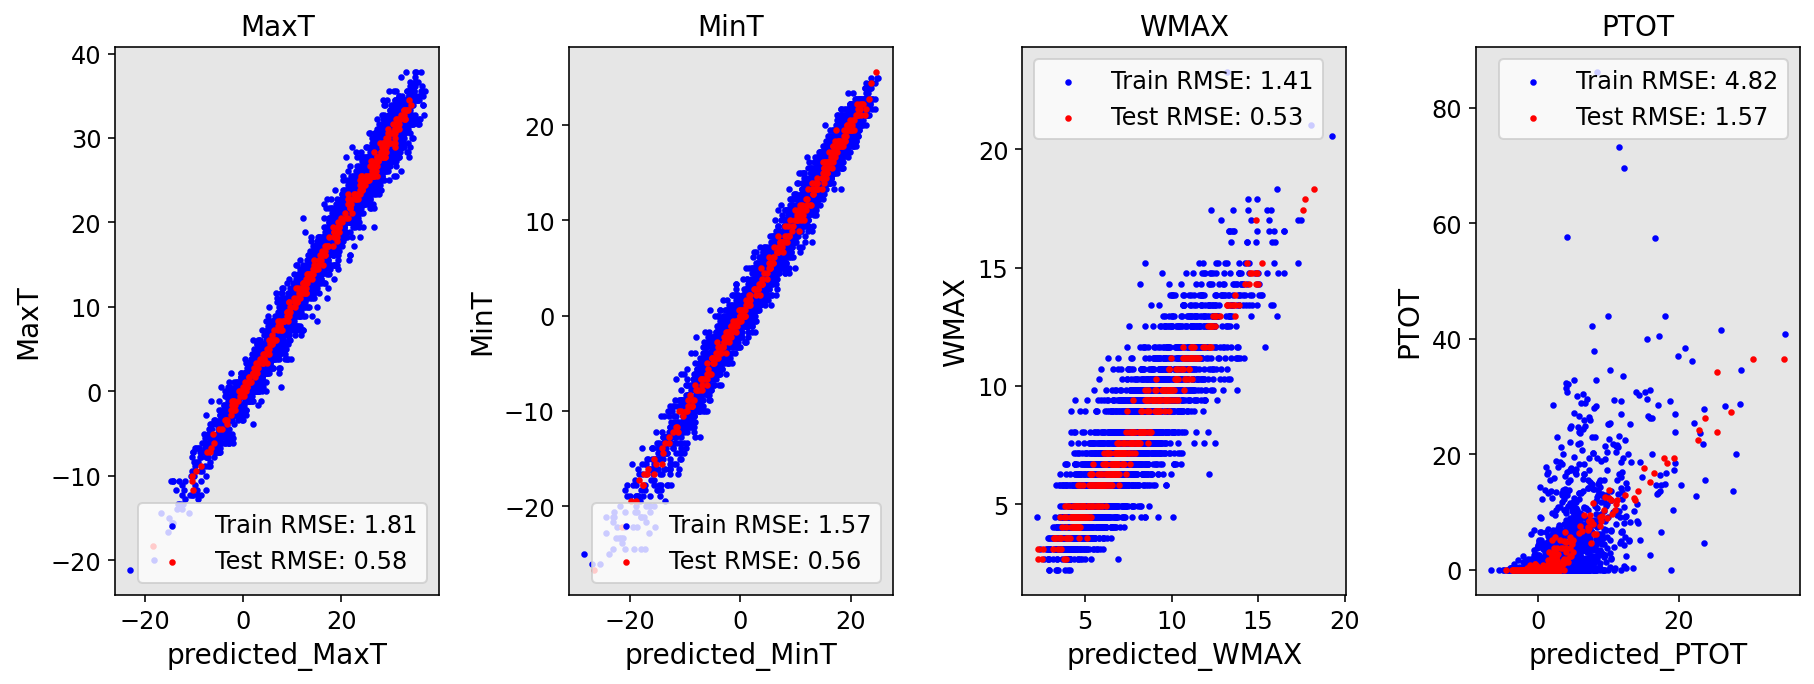

In [0]:
# Plot Results

plt.figure(figsize=(12,8))
ax = plt.subplot(141)
data3.plot.scatter(x = 'predicted_MaxT', y = 'MaxT', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (MaxT3_RMSE), ax=ax)
data4.plot.scatter(x = 'predicted_MaxT', y = 'MaxT', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (MaxT4_RMSE), ax=ax)
ax2 = plt.subplot(142)
data3.plot.scatter(x = 'predicted_MinT', y = 'MinT', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (MinT3_RMSE), ax=ax2)
data4.plot.scatter(x = 'predicted_MinT', y = 'MinT', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (MinT4_RMSE), ax=ax2)
ax3 = plt.subplot(143)
data3.plot.scatter(x = 'predicted_WMAX', y = 'WMAX', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (WMAX3_RMSE), ax=ax3)
data4.plot.scatter(x = 'predicted_WMAX', y = 'WMAX', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (WMAX4_RMSE), ax=ax3)
ax4 = plt.subplot(144)
data3.plot.scatter(x = 'predicted_PTOT', y = 'PTOT', marker = '.', color = 'blue', label = 'Train RMSE: %.2f' % (PTOT3_RMSE), ax=ax4)
data4.plot.scatter(x = 'predicted_PTOT', y = 'PTOT', marker = '.', color = 'red', label = 'Test RMSE: %.2f' % (PTOT4_RMSE), ax=ax4)

ax.title.set_text('MaxT')
ax2.title.set_text('MinT')
ax3.title.set_text('WMAX')
ax4.title.set_text('PTOT')

plt.subplots_adjust(top = 0.6, right = 1.1, wspace = 0.4)
plt.show()